In [1]:
import os 

data_dir = '/kaggle/input/biggest-genderface-recognition-dataset/faces'

os.listdir(data_dir)

['man', 'woman']

In [2]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
# Configuração
SIZE = 128
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Diretórios dos datasets
data_dir = '/kaggle/input/biggest-genderface-recognition-dataset/faces'
data_test = '/kaggle/input/gender-detection-and-classification-image-dataset'

# Criar datasets de treino e validação
def load_dataset(directory, validation_split=None, subset=None):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=123,
        image_size=(SIZE, SIZE),
        batch_size=BATCH_SIZE)

train_ds = load_dataset(data_dir, validation_split=0.2, subset="training")
val_ds = load_dataset(data_dir, validation_split=0.2, subset="validation")
ds_test = load_dataset(data_test)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 27167 files belonging to 2 classes.
Using 21734 files for training.
Found 27167 files belonging to 2 classes.
Using 5433 files for validation.
Found 300 files belonging to 2 classes.
Classes: ['man', 'woman']


In [5]:
train_size = len(train_ds) * BATCH_SIZE
val_size = len(val_ds) * BATCH_SIZE
test_size = len(ds_test) * BATCH_SIZE

print(f"Tamanho do conjunto de treinamento: {train_size} imagens")
print(f"Tamanho do conjunto de validação: {val_size} imagens")
print(f"Tamanho do conjunto de teste: {test_size} imagens")

num_classes = len(class_names)
print(f"Número de classes: {num_classes}")


Tamanho do conjunto de treinamento: 21744 imagens
Tamanho do conjunto de validação: 5440 imagens
Tamanho do conjunto de teste: 304 imagens
Número de classes: 2


In [6]:
# Balanceamento do dataset
homens, mulheres = [], []
for batch, labels in train_ds:
    for img, label in zip(batch, labels):
        (homens if label == 0 else mulheres).append((img, label))

tamanho_menor_classe = min(len(homens), len(mulheres))
homens_reduzidos = random.sample(homens, tamanho_menor_classe)
balanced_data = homens_reduzidos + mulheres
random.shuffle(balanced_data)

imgs, labels = zip(*balanced_data)
imgs_tensor, labels_tensor = tf.stack(imgs), tf.convert_to_tensor(labels)

balanced_train_ds = tf.data.Dataset.from_tensor_slices((imgs_tensor, labels_tensor))
balanced_train_ds = balanced_train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Verificando a quantidade de imagens de cada classe antes do balanceamento
print(f"Quantidade de homens antes do balanceamento: {len(homens)}")
print(f"Quantidade de mulheres antes do balanceamento: {len(mulheres)}")

# Quantidade após o balanceamento
print(f"Quantidade de homens após o balanceamento: {len(homens_reduzidos)}")
print(f"Quantidade de mulheres após o balanceamento: {len(mulheres)}")

# Também podemos verificar no dataset final balanceado
balanced_homens = sum(1 for _, label in balanced_data if label == 0)
balanced_mulheres = sum(1 for _, label in balanced_data if label == 1)

print(f"Quantidade de homens no dataset balanceado: {balanced_homens}")
print(f"Quantidade de mulheres no dataset balanceado: {balanced_mulheres}")


Quantidade de homens antes do balanceamento: 14173
Quantidade de mulheres antes do balanceamento: 7561
Quantidade de homens após o balanceamento: 7561
Quantidade de mulheres após o balanceamento: 7561
Quantidade de homens no dataset balanceado: 7561
Quantidade de mulheres no dataset balanceado: 7561


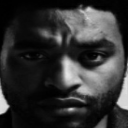

Classe: man


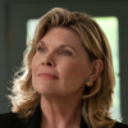

Classe: woman


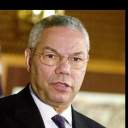

Classe: man


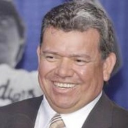

Classe: man


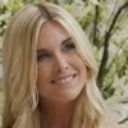

Classe: woman


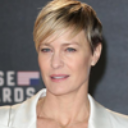

Classe: woman


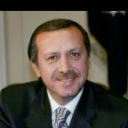

Classe: man


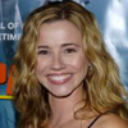

Classe: woman


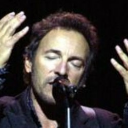

Classe: man


In [8]:
import cv2
import numpy as np
from IPython.display import display, Image
import random

def plot_images(dataset, class_names):
    # Converter o dataset para uma lista
    images_list = []
    labels_list = []
    
    # Preencher listas com imagens e rótulos
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    
    # Flatten listas para facilitar a seleção aleatória
    all_images = np.concatenate(images_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    
    # Selecionar aleatoriamente 9 imagens
    random_indices = random.sample(range(len(all_images)), 9)
    
    for i in random_indices:
        img = all_images[i].astype("uint8")  # Convertendo a imagem para uint8
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convertendo de RGB para BGR (OpenCV usa BGR)

        # Convertendo a imagem para um formato que o IPython pode exibir
        _, img_encoded = cv2.imencode('.png', img)
        img_display = img_encoded.tobytes()  # Convertendo para bytes

        # Exibindo a imagem com IPython
        display(Image(data=img_display, format='png', width=200))

        # Mostrando o título da classe
        print(f"Classe: {class_names[all_labels[i]]}")

plot_images(balanced_train_ds, class_names)


In [9]:


# Criar modelo EfficientNet
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3)
)


print(f'Total layers in base model: {len(base_model.layers)}')

base_model.trainable = False  # Congelar base no início

inputs = layers.Input(shape=(SIZE, SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(x)

model = tf.keras.Model(inputs, outputs)


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
 #   initial_learning_rate=1e-4,
  #  decay_steps=100000,  # Número de etapas antes de decair
   # decay_rate=0.96,  # Taxa de decaimento
    #staircase=True
#)



# Compilação inicial
model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              verbose=1)



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/best_model.keras', save_best_only=True, monitor='val_loss', mode='min'
)

# Treinamento inicial (apenas cabeçalho do modelo)
history = model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[reduce_lr]
)
print()
print("Fine Tuning")
print()
# Fine-Tuning: descongelar parte da base
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

history_fine = model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in base model: 238
Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.7875 - auc: 0.8713 - loss: 0.4687 - val_accuracy: 0.9026 - val_auc: 0.9630 - val_loss: 0.2533 - learning_rate: 1.0000e-05
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8909 - auc: 0.9578 - loss: 0.2749 - val_accuracy: 0.9080 - val_auc: 0.9670 - val_loss: 0.2317 - learning_rate: 1.0000e-05
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8959 - auc: 0.9617 - loss: 0.2577 - val_accuracy: 0.9105 - val_auc: 0.9686 - val_loss: 0.2262 - learning_rate: 1.0000e-05
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8999 - auc: 0.9642 - loss: 0.2490 - val_accuracy: 0.9120 - val_auc: 0.9696 - val_loss: 0.2214 - learning_rate: 1.0000e-05
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8958 - auc: 0.9632 - loss: 0.2514 - val_accuracy: 0.9139 - val_auc: 0.9702 - val_loss: 0.

340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9222 - auc_1: 0.9767 - loss: 0.2015
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 606ms/step - accuracy: 0.5825 - auc_1: 0.5185 - loss: 1.3567
Validação - Perda: 0.20523205399513245, Acurácia: 0.9193815588951111, AUC: 0.9763892889022827
Teste - Perda: 1.5815989971160889, Acurácia: 0.5166666507720947, AUC: 0.4392329454421997
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


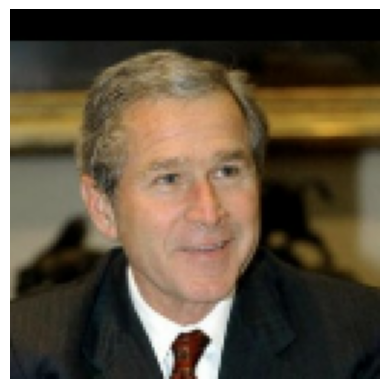

Previsão: Man (Probabilidade: 0.0000)
Rótulo verdadeiro: man


In [10]:
# Avaliação
val_results = model.evaluate(val_ds)
test_results = model.evaluate(ds_test)

print(f"Validação - Perda: {val_results[0]}, Acurácia: {val_results[1]}, AUC: {val_results[2]}")
print(f"Teste - Perda: {test_results[0]}, Acurácia: {test_results[1]}, AUC: {test_results[2]}")

# Teste de previsão
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_sample(model, dataset, class_names):
    for image_batch, labels_batch in dataset.take(1):
        test_image = image_batch[0]
        test_label = labels_batch[0]
    
    test_image = preprocess_input(test_image)  # Correção na normalização
    test_image = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image)
    
    predicted_class = "Woman" if prediction >= 0.5 else "Man"
    true_class = class_names[int(test_label)]  # Correção na classe verdadeira
    
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Exibir imagem corretamente
    plt.axis('off')
    plt.show()
    
    print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")
    print(f"Rótulo verdadeiro: {true_class}")

predict_sample(model, train_ds, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


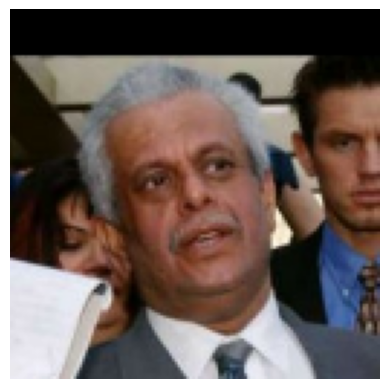

Previsão: Man (Probabilidade: 0.0046)
Rótulo verdadeiro: man


In [11]:
predict_sample(model, train_ds, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


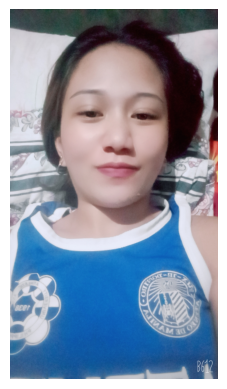

Previsão: Woman (Probabilidade: 0.8705)


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# 📌 Carregar o modelo treinado
model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

# 📌 Função para carregar e pré-processar a imagem
def preprocess_image(image_path, target_size=(SIZE, SIZE)):
    image = Image.open(image_path)  # Abrir imagem
    image = image.resize(target_size)  # Redimensionar
    image = np.array(image)  # Converter para array
    image = preprocess_input(image)  # Aplicar pré-processamento do EfficientNet
    image = np.expand_dims(image, axis=0)  # Adicionar batch dimension
    return image

# 📌 Caminho da imagem que você quer testar
#image_path = "/kaggle/input/gender-detection-and-classification-image-dataset/test/men/112.jpg"
image_path = '/kaggle/input/gender-detection-and-classification-image-dataset/test/women/125.jpg'

# 📌 Carregar e processar a imagem
image = preprocess_image(image_path)

# 📌 Fazer a previsão
prediction = model.predict(image)

# 📌 Determinar a classe prevista
predicted_class = "Woman" if prediction >= 0.5 else "Man"

# 📌 Exibir a imagem e o resultado
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


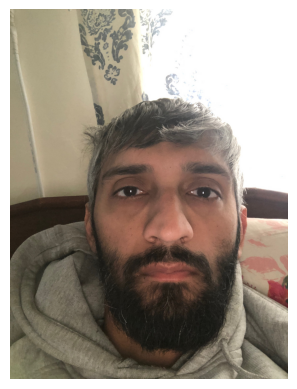

Previsão: Man (Probabilidade: 0.0006)


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# 📌 Carregar o modelo treinado
model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

# 📌 Função para carregar e pré-processar a imagem
def preprocess_image(image_path, target_size=(SIZE, SIZE)):
    image = Image.open(image_path)  # Abrir imagem
    image = image.resize(target_size)  # Redimensionar
    image = np.array(image)  # Converter para array
    image = preprocess_input(image)  # Aplicar pré-processamento do EfficientNet
    image = np.expand_dims(image, axis=0)  # Adicionar batch dimension
    return image

# 📌 Caminho da imagem que você quer testar
image_path = "/kaggle/input/gender-detection-and-classification-image-dataset/test/men/120.jpg"
#image_path = '/kaggle/input/gender-detection-and-classification-image-dataset/test/women/139.jpg'

# 📌 Carregar e processar a imagem
image = preprocess_image(image_path)

# 📌 Fazer a previsão
prediction = model.predict(image)

# 📌 Determinar a classe prevista
predicted_class = "Woman" if prediction >= 0.5 else "Man"

# 📌 Exibir a imagem e o resultado
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

print(f"Previsão: {predicted_class} (Probabilidade: {prediction[0][0]:.4f})")
